In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
import torch


Kiểm tra CUDA Toolkit

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load local MNIST

In [2]:
mnist_folder = "./MNIST_Dataset"

LoadMNIST from https://stackoverflow.com/a/53226079

In [3]:
def loadMNIST(prefix, folder):
    
    data_path = "-images-idx3-ubyte"
    labels_path = "-labels-idx1-ubyte"

    intType = np.dtype('int32').newbyteorder('>')
    nMetaDataBytes = 4 * intType.itemsize
    
    data = np.fromfile(folder + "/" + prefix + data_path, dtype = 'ubyte')
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType)
    data = data[nMetaDataBytes:].astype( dtype='float32').reshape([nImages, width, height])
    
    labels = np.fromfile(folder + "/" + prefix + labels_path, dtype = 'ubyte')[2 * intType.itemsize:]
    
    return data, labels

In [4]:
trainingImages, trainingLabels = loadMNIST( "train", mnist_folder )
testImages, testLabels = loadMNIST( "t10k", mnist_folder )

__Test MNIST loader__

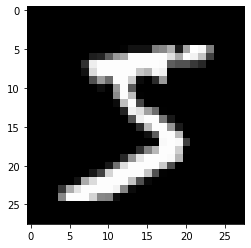

In [24]:
img1 = trainingImages[0]

img1_2d = np.reshape(img1, (28, 28))

plt.subplot(111)
plt.imshow(img1_2d, cmap=plt.get_cmap('gray'))
plt.show()

## 2. CNN Models
### 2.1. CNN Layers [6, 7]
#### a. Convolution layer
Simple convolution layer with: 
+ Filter: 3x3xN (N: num_filters)
+ Padding: "valid" or "same"


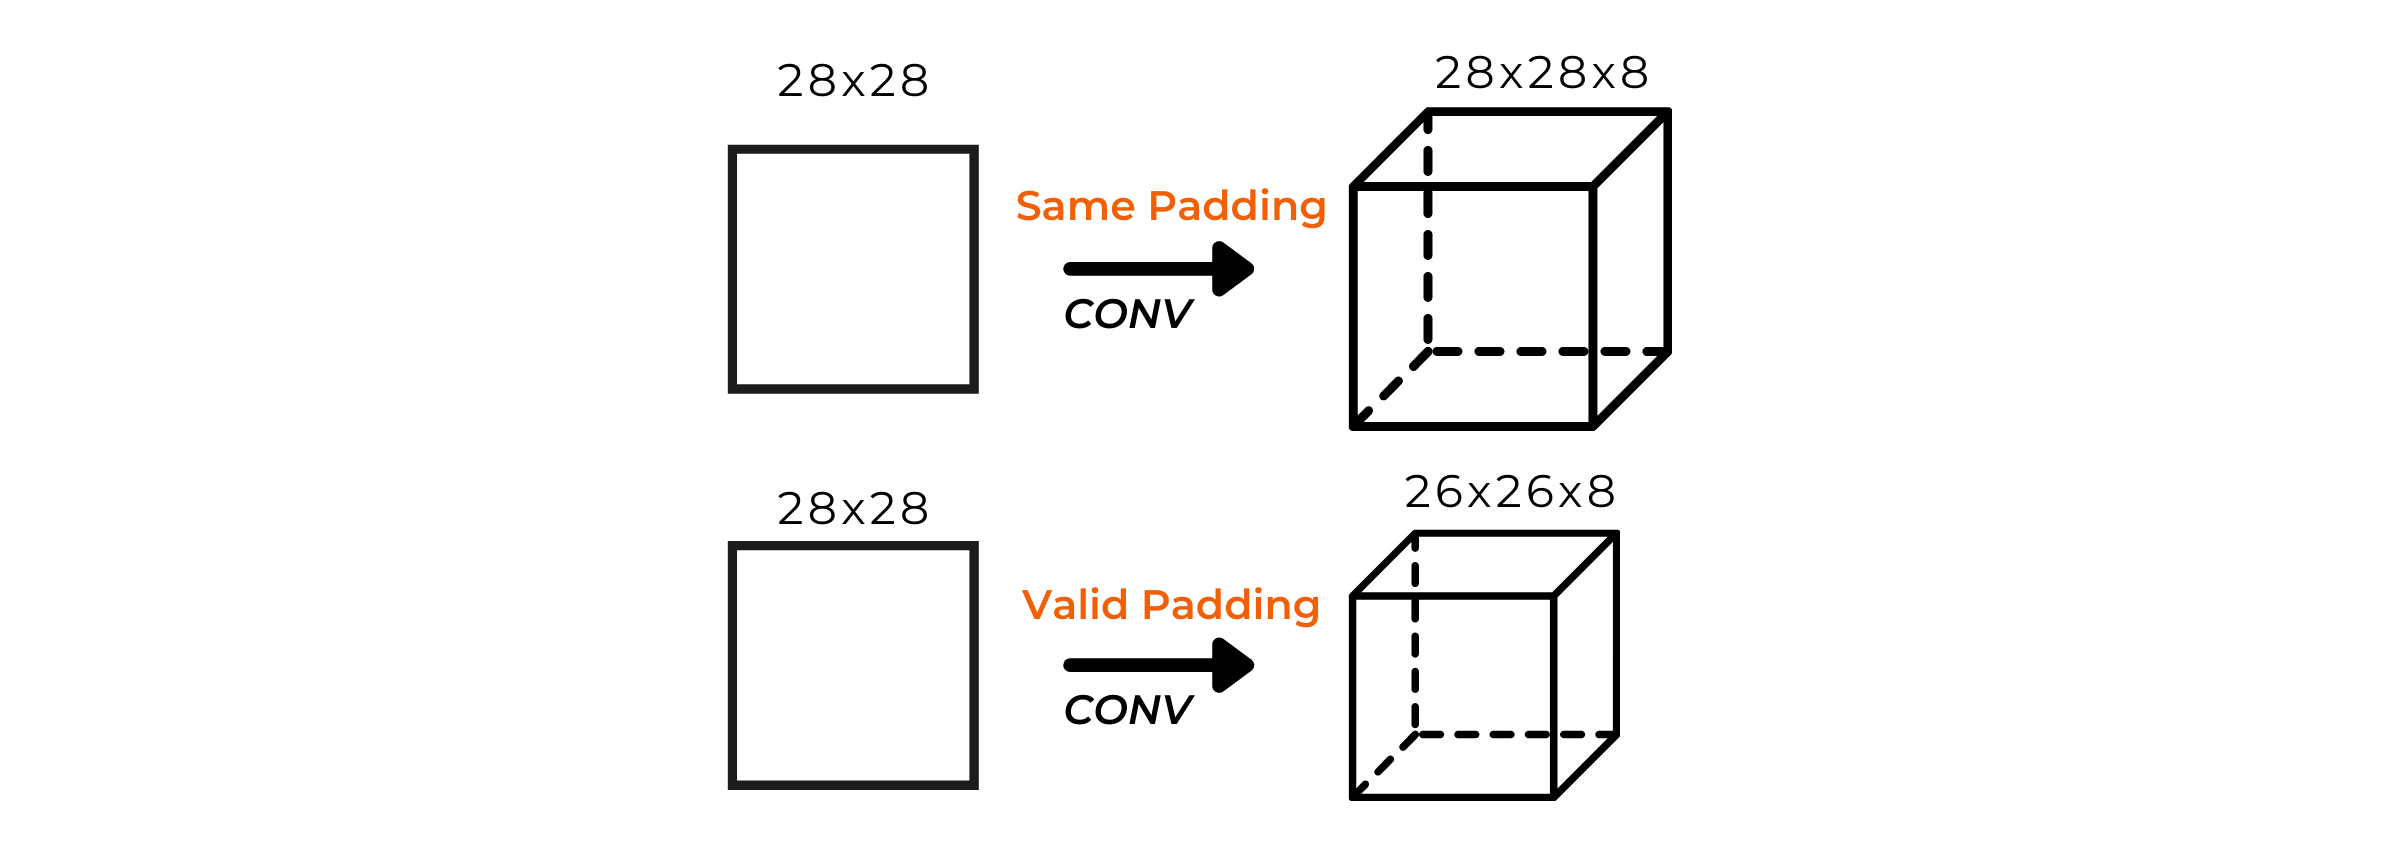

In [40]:
class Conv: 
    def __init__(
        self, 
        num_filters, 
        padding: str = "valid"
    ):
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, 3, 3)/9
        self.padding = padding
    
    def iterate_regions(self, image):
        h, w =  image.shape
        
        #Same Padding
        if (self.padding == "same"):
            pad_image = np.pad(image, 1, mode='constant')
            for i in range(h):
                for j in range(w):
                    img_region = pad_image[i:(i+3), j:(j+3)]
                    yield img_region, i, j
                    
        #Valid Padding            
        elif (self.padding == "valid"):
            for i in range(h-2):
                for j in range(w-2):
                    img_region = image[i:(i+3), j:(j+3)]
                    yield img_region, i, j
        else:
            raise Exception(
                f"Unsupported padding value: {self.padding}"
            )
        
    def forward(self, input):
        self.last_input = input
        
        h, w = input.shape

        #Same Padding
        if (self.padding == "same"):
            output = np.zeros((h, w, self.num_filters))
                    
        #Valid Padding            
        elif (self.padding == "valid"):
            output = np.zeros((h-2, w-2, self.num_filters))

        else:
            raise Exception(
                f"Unsupported padding value: {self.padding}"
            )
                
        for img_region, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(img_region * self.filters, axis=(1, 2))

        return output
    
    def backpropagation(self, dL_dout, learning_rate):
        dL_dfilters = np.zeros(self.filters.shape)
        
        for img_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                dL_dfilters[f] += dL_dout[i, j, f] * img_region
                
        self.filters -= learning_rate * dL_dfilters
        
        return None

##### #3 Backpropagation on Convolution layer [6, 12]: 
$$\frac{\partial L}{\partial filter(x, y)} = \sum_{i}\sum _{j}\frac{\partial L}{\partial out(i, j)} * \frac{\partial out(i, j)}{\partial filter(x, y)}$$

#### b. MaxPooling Layer with 2x2 windows


In [48]:
class MaxPool:
    def iterate_region(self, image):
        h, w, _ = image.shape
        h_new = h // 2
        w_new = w // 2
        
        for i in range(h_new):
            for j in range(w_new):
                img_region = image[(i*2):(i*2+2), (j*2):(j*2+2)]
                yield img_region, i, j
    
    def forward(self, input):
        self.last_input = input
        h, w, num_filters = input.shape
        
        pool_output = np.zeros((h//2, w//2, num_filters))
        for img_region, i, j in self.iterate_region(input):
            pool_output[i, j] = np.amax(img_region, axis=(0, 1))
        return pool_output
    
    def backpropagation(self, dL_dout):
        dL_dinput = np.zeros(self.last_input.shape)

        for img_region, j, j in self.iterate_region(self.last_input):
            #shape of convolution layer's output
            h, w, f = img_region.shape
            #get max_pool
            amax = np.amax(img_region, axis=(0, 1))
            for ih in range(h):
                for jw in range(w):
                    for f2 in range(f):
                        if(img_region[ih,jw,f2] == amax[f2]):
                            #Counting in range
                            if((i*2+ih < h) and (j*2+jw < w)):
                                dL_dinput[i*2+ih, j*2+jw ,f2] = dL_dout[i, j, f2]
        return dL_dinput

##### #2 Backpropagation on Max Pooling layer [6] with 2x2 window: 
+ $\frac{\partial L}{\partial input} = 0$ for non-max pixels
+ $\frac{\partial L}{\partial input}  = \frac{\partial L}{\partial output}$ for max-value pixels

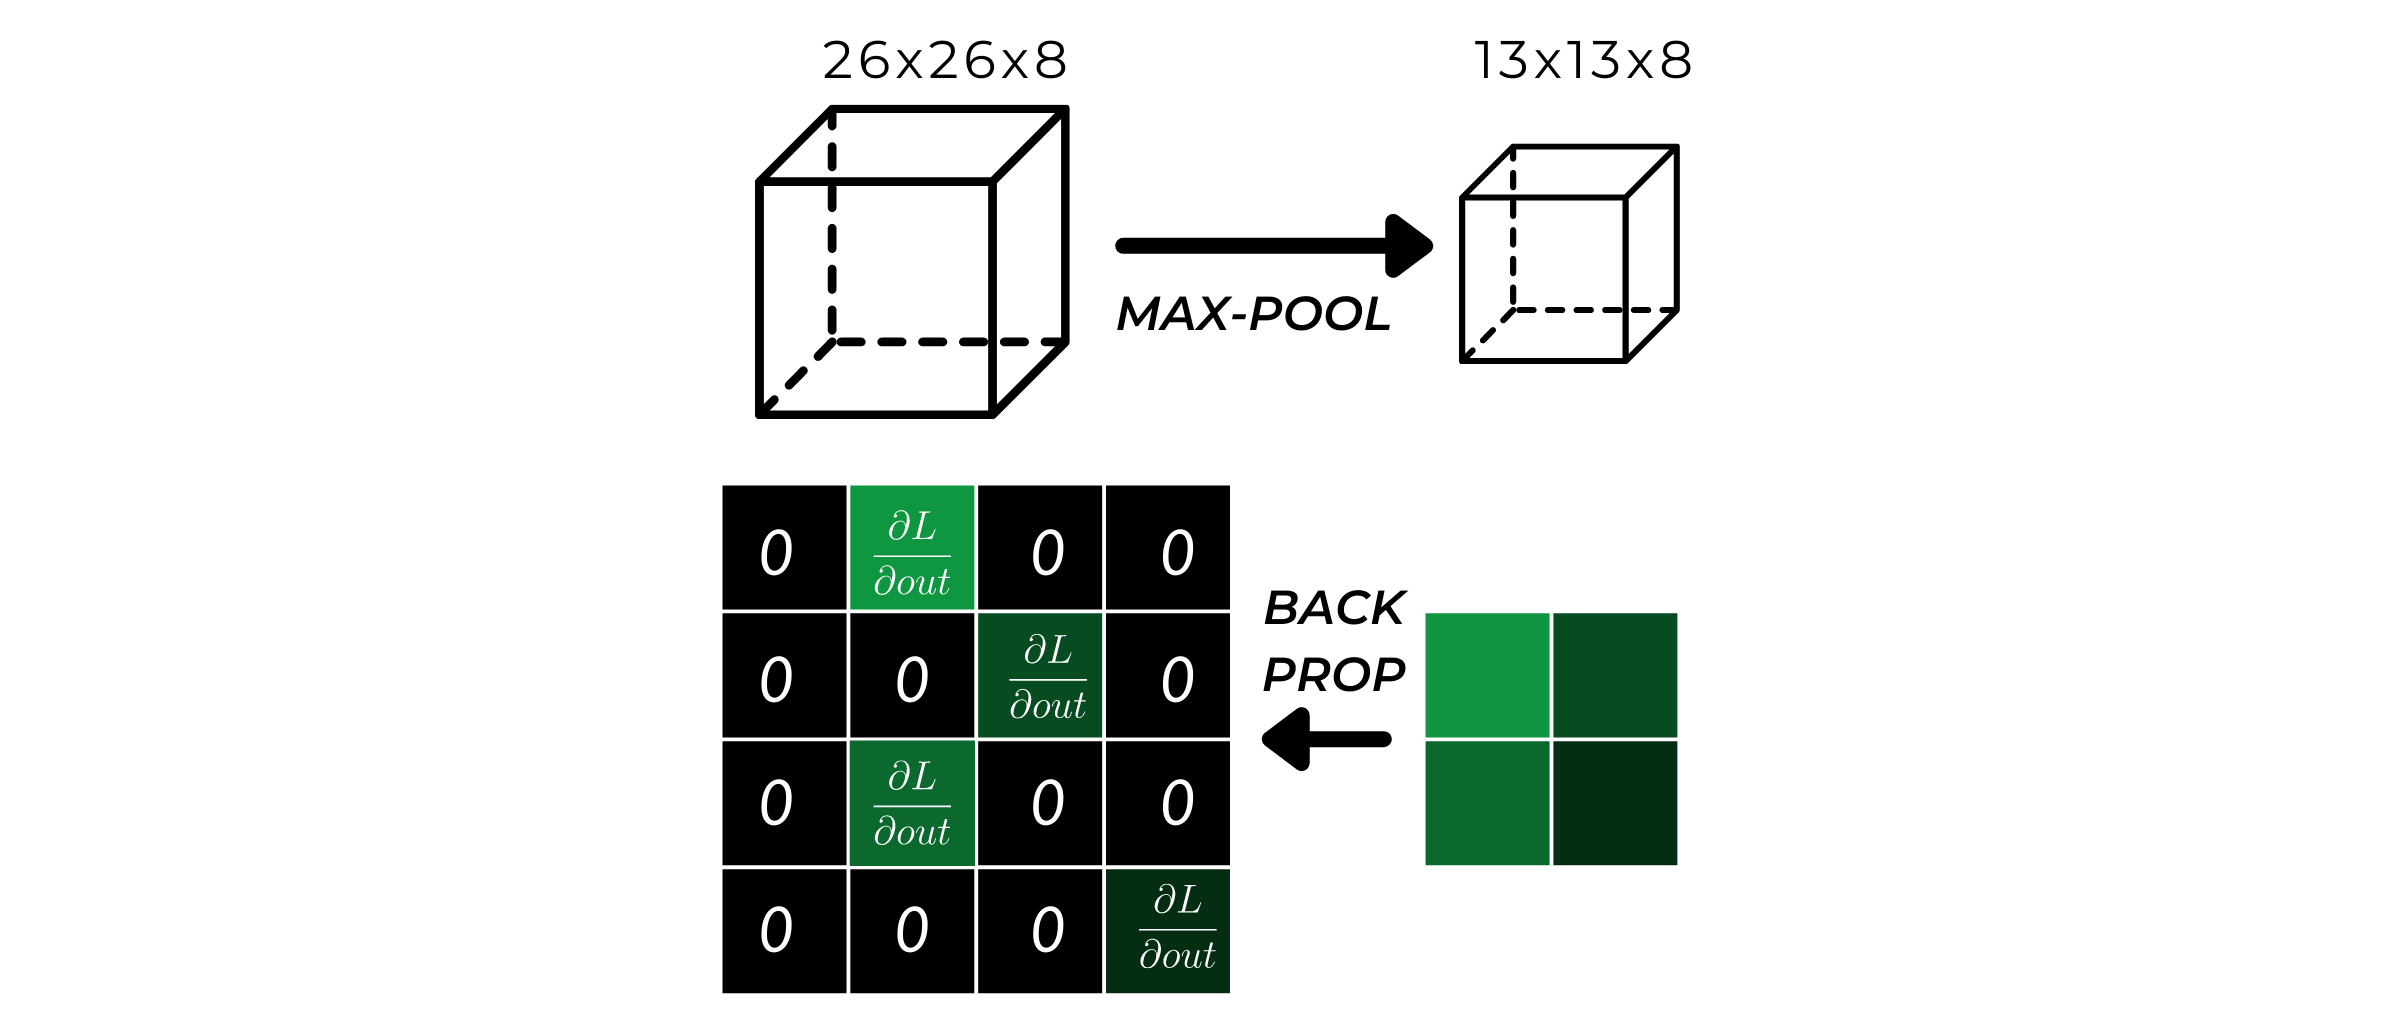

#### c. Softmax Layer
__Softmax function:__ $$f_i(x) = \frac{e^{x_i}}{\sum_{j}e^{x_j}}$$, with $x \in \{0, 9\}$


In [10]:
class Softmax:
    def __init__(self, input_len, nodes):
        self.weights = np.random.randn(input_len, nodes)/input_len
        self.bias = np.zeros(nodes)
        
    def forward(self, input):
        #Input shape before Flatten
        self.last_input_shape = input.shape
        
        #Flatten Max-Pooling output
        input = input.flatten()
        self.last_input = input
        
        input_len, nodes = self.weights.shape
        
        #Fully Connected
        totals = np.dot(input, self.weights) + self.bias
        self.last_totals = totals
        
        exp = np.exp(totals)
        return (exp/np.sum(exp, axis = 0))
    
    def backpropagation(self, dL_dout, learning_rate):
        for i, gradient in enumerate(dL_dout):
            #dL_dout = gradient
            if gradient == 0:
                continue
            
            #e^total
            t_exp = np.exp(self.last_totals)
            
            #Sum of e^total, denominator of Softmax function
            S = np.sum(t_exp)
            
            #Gradients of out[i] against totals
            dout_dt = -t_exp[i] * t_exp / (S**2)
            # - with i = c, update dout_dt[i]
            dout_dt[i] = t_exp[i] * (S-t_exp[i]) / (S**2)
            
            #Gradient of total against weights/bias/inputs
            dt_dw = self.last_input
            dt_db = 1
            dt_dinputs = self.weights
            
            #Gradients of loss against totals
            #dL_dt = dL_dout a.k.a gradient * dout_dt
            dL_dt = gradient * dout_dt
            
            #Gradients of loss against weights/biases/input
            # + [Vector] dt_dw.Transform x [Vector] dL_dt
            # + Dimension dL_dw: (input_len, 1) x (1, nodes) 
            dL_dw = dt_dw[np.newaxis].T @ dL_dt[np.newaxis]
            dL_db = dL_dt * dt_db
            # + Dimension dL_dinputs: (input_len, nodes) x (nodes, 1)
            dL_dinputs = dt_dinputs @ dL_dt
            
            self.weights -= learning_rate * dL_dw
            self.bias -= learning_rate * dL_db
        
        # return gradient dL_dinputs with shape from the previous layer's output
        return dL_dinputs.reshape(self.last_input_shape)

##### #1 Backpropagation on Softmax [6, 10, 11]: 
__Gradients of Cross-entropy loss against Softmax layer's input:__
$$\frac{\partial L}{\partial input} = \frac{\partial L}{\partial out} * \frac{\partial out}{\partial t} * \frac{\partial t}{\partial input}$$
Trong đó: 
+ Gradients of totals against input: $$\frac{\partial t}{\partial input} = \frac{\partial (w*input +b)}{\partial input} = w$$
+ Gradients of $out_i$ against _totals_ $S$: $$\frac{\partial out_s(i)}{\partial t} = \begin{cases}
 \frac{-e^{t_c}e^{t_i}}{S^2} & \text{ if } i\neq c\\
 -\frac{e^{t_c}(S-e^{t_c})}{S^2}& \text{ if } i = c 
\end{cases}$$ 
+ Gradients of Cross-entropy loss for this layer's outputs: $$\frac{\partial L}{\partial out} = \begin{cases}
 0 & \text{ if } i\neq c\\
 -\frac{1}{p_i}& \text{ if } i = c 
\end{cases}$$ 



__Gradients of Cross-entropy loss against weights:__
$$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial out} * \frac{\partial out}{\partial t} * \frac{\partial t}{\partial w}$$
__Gradients of Cross-entropy loss against bias:__
$$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial out} * \frac{\partial out}{\partial t} * \frac{\partial t}{\partial b}$$


### 2.2 Some CNN Models


#### a. CNN models without non-linear activation layer
##### Shallow CNN - Conv: same padding

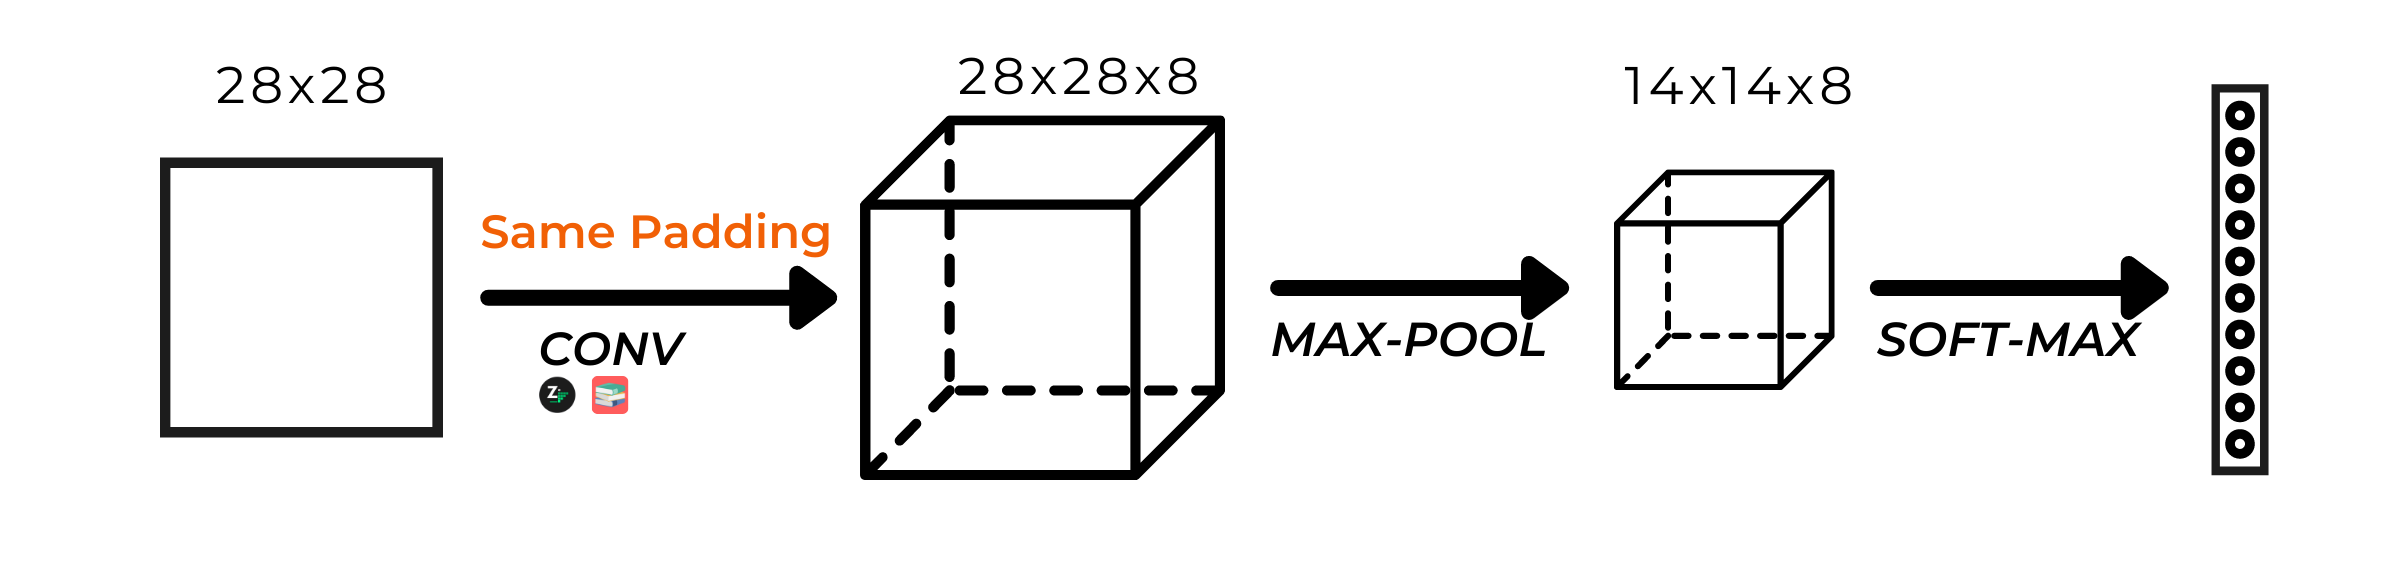

In [54]:
SCNN_conv = Conv(8, "same")
SCNN_pool = MaxPool()
SCNN_softmax = Softmax(14*14*8, 10)

def forward(image, label):
    
    out = SCNN_conv.forward((image/255) - 0.5)    
    out = SCNN_pool.forward(out)
    out = SCNN_softmax.forward(out)

    loss = -np.log(out[label])
    acc = 1 if(np.argmax(out) == label) else 0
    
    return out, loss, acc

def train(img, label, lr=0.05):
    out, loss, acc = forward(img, label)
    
    gradient = np.zeros(10)
    gradient[label] = -1/out[label]
    
    gradient = SCNN_softmax.backpropagation(gradient, lr)
    gradient = SCNN_pool.backpropagation(gradient)
    gradient = SCNN_conv.backpropagation(gradient, lr)
    
    return loss, acc



In [ ]:
print('MNIST Shallow CNN initialized')

for epoch in range(3):
    print('----EPOCH %d ---'%(epoch+1))

    #shuffle the training data
    permutation = np.random.permutation(len(trainingImages))
    trainingImages = trainingImages[permutation]
    trainingLabels = trainingLabels[permutation]


    loss = 0
    num_correct = 0

    for i, (im, label) in enumerate(zip(trainingImages, trainingLabels)):

        #print stats every 100 steps
        if(i>0 and i % 100 == 99):
            print('[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %(i + 1, loss / 100, num_correct))

            loss = 0
            num_correct = 0
        l, acc = train(im, label)
        loss += l
        num_correct += acc

##### Sigmoid Activation 

In [ ]:
def class Sigmoid:

##### ReLU Activation

In [ ]:
class ReLU: 
    

#### b. CNN with Residual

# Reference
1. Goodfellow, I., Bengio, Y., & Courville, A. (2016). __Deep learning__. MIT press.
2. Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, november 1998. URL: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf
3. __Numpy CNN__, URL: https://github.com/SkalskiP/ILearnDeepLearning.py/tree/master/01_mysteries_of_neural_networks/06_numpy_convolutional_neural_net
4. Ahmed Gad, __Building Convolutional Neural Network using NumPy from Scratch__, URL: https://towardsdatascience.com/building-convolutional-neural-network-using-numpy-from-scratch-b30aac50e50a
5. Chi-Feng Wang, __The Vanishing Gradient Problem__, URL: https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484
6. Victor Zhou, __CNNs, Part 1: An Introduction to Convolutional Neural Networks__, URL: https://victorzhou.com/blog/intro-to-cnns-part-1/
7. Victor Zhou, __CNNs, Part 2: Training a Convolutional Neural Network__, URL: https://victorzhou.com/blog/intro-to-cnns-part-2/
8. Mehrdad Yazdani, __What is an intuitive explanation of the Xavier Initialization for Deep Neural Networks?__ Quora, URL: https://qr.ae/pGVZY4
9. Piotr Skalski, __Let’s Code Convolutional Neural Network in plain NumPy__, URL: https://towardsdatascience.com/lets-code-convolutional-neural-network-in-plain-numpy-ce48e732f5d5
10. __Convolutional Neural Networks (CNN): Softmax & Cross-Entropy__, SuperDataScience, URL: https://www.superdatascience.com/blogs/convolutional-neural-networks-cnn-softmax-crossentropy
11. Raúl Gómez, __Understanding Categorical Cross-Entropy Loss, Binary Cross-Entropy Loss, Softmax Loss, Logistic Loss, Focal Loss and all those confusing names__, May 23, 2018, URL: https://gombru.github.io/2018/05/23/cross_entropy_loss/
12. Matt Mazur, __A Step by Step Backpropagation Example__, URL https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
13. milan, "CNN from scratch(numpy)", Kaggle, URL: https://www.kaggle.com/milan400/cnn-from-scratch-numpy/notebook
14. lpraat, __numpyCNN__, Github, URL: https://github.com/lpraat/numpyCNN
15. Piotr Skalski, __ILearnDeepLearning.py__, Github, URL: https://github.com/SkalskiP/ILearnDeepLearning.py/tree/master/01_mysteries_of_neural_networks/06_numpy_convolutional_neural_net